In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
import os
from glob import glob
from re import match, search
from statistics import variance

In [2]:
def get_data_files(path_to_flame_data):
    """
    Grabs and formats the data outputted by the flame code (ignite.byu.edu), then exports an array with the following:
        all_data = dictionary with the data from each file indexed using the filename as the key. using all_data[file#][column# = Property][row # = data point]
        headers = dictionary with the column labels indexed using the filename as the key.
            All indices should be the same for a given instance of the flame code, but all headers have been redundantly included.
        extras = dictionary with the extra information included at the beginning of a data file, indexed using the filename as the key.
            This data is included in unformatted form.
    """
    # Check if the provided path is a valid directory
    if not os.path.isdir(path_to_flame_data):
        print(f"Error: {path_to_flame_data} is not a valid directory.")
        return None
    
    # Define regex to grab only data files
    file_pattern = r'^L.*\.dat$'
    
    # Use glob to list all files in the directory
    files = glob(os.path.join(path_to_flame_data, '*'))
    
    # Store data in a dictionary with the filename as the key
    data_files = {os.path.basename(file): file for file in files if match(file_pattern, os.path.basename(file))}

    # Initialize data arrays
    all_data = {} #initialize to grab data values
    headers = {} #Initialize to store headers
    extras = {} #initialize to store extra info before header

    #Grab and store data
    for key in data_files.keys():
        file = data_files[key]
        with open(file, 'r') as f:
            lines = f.readlines()
            data = [line.strip() for line in lines if not line.startswith('#')]

            # Grab the header and extra data (included as commented lines and column labels
            IsHeader = True
            header = []
            extra = []
            for line in reversed(lines):
                if line.startswith('#'):
                    vals = [val for val in line.strip().split() if val !='#']
                    if IsHeader == True:
                        for val in vals:
                            #Remove preemtive numbers in the column labels, then store column label
                            #This is used later to select which column of data to use when creating the table
                            header = np.append(header, val.split("_")[1])
                        IsHeader = False
                    else:
                        for val in vals:
                            extra.append(val)
        
        headers[key] = header
        extras[key] = extra
        
        # Parse out numerical values, then append data to all_data
        file_data = [] # will hold each file's data
        for row in data:
            numbers = [float(val) for val in row.split()]
            file_data.append(numbers)

        #Transponse data so that each property has it's own list
        transposed_file_data = [list(x) for x in zip(*file_data)]
        
        #Arrange data in a dictionary: all_data[fileName][propertyIndex][data_point]
        all_data[key] = transposed_file_data

    return all_data, headers, extras
#get_data_files("/home/jaredwp91/Research/mnt/inferno/codes/flameJWP/run")[0]

In [3]:
def phiFuncs(path_to_flame_data, phi = 'T', fileName = False):
    """
    Uses the given path to directory holding data outputted from the flame code (ignite.byu.edu) to grab these datafiles 
    and return an array of interpolated functions phi(ξ).
    Inputs:
        path_to_flame_data = the path on the local machine pointing to the flame code's main directory
        fileName = If set to false, the output will be an array of the functions phi(ξ) for all datafiles. Otherwise, this determines
            which specific file should be used. 
            Example1: phiFuncs(path, phi = 'T', fileName = 'L_0.002U_1.dat'): returns the interpolated T(ξ) function from L_0.002U_1.dat ONLY
            Example2: phiFuncs(path, phi = 'T'): returns an array containing the interpolated T(ξ) functions from each file in the directory
    """
    #Import data, files, and headers
    data, headers, extras = get_data_files(path_to_flame_data)
    
    #Get list of available phi (list of all data headers from original files)
    if type(fileName) == bool:
        #This assumes all datafiles have the same column labels and ordering
        phis = headers[list(headers.keys())[0]] 
    else:
        phis = headers[fileName]
    
    #Interpret user input for "phi", find xi column
    phi_col = -1
    xi_col = -1
    for i in range(len(phis)):
        if phis[i].lower()==phi.replace(" ","").lower():
            phi_col = i
        if phis[i].lower()=="mixf":
            xi_col = i
    if phi_col == -1:
        raise ValueError("{} not recognized. Available phi are:\n {}".format(phi, phis))
        return None
    if xi_col == -1:
        raise ValueError("Mixture fraction ('mixf') was not found among data coumns.")
        return None

    #Interpolate phi(xi)
    phiFuncs = {}
    if type(fileName) == bool:
        #Have to interpolate for every file
        for key in data.keys():
            xis = data[key][xi_col]
            phis = data[key][phi_col]
            func = interp1d(xis, phis, kind = 'cubic')
            phiFuncs[key] = func
        return phiFuncs
    else:
        xis = data[fileName][xi_col]
        phis = data[fileName][phi_col]
        func = interp1d(xis, phis, kind = 'cubic')
        return func

    raise ValueError("Error in code execution: no functions were returned.")
    return None #Code should never reach here

#phiFuncs("/home/jaredwp91/Research/mnt/inferno/codes/flameJWP/run", fileName = 'L_0.002U_24.dat')

# Making the Table:

In [4]:
def lookupTable(path_to_flame_data, phi, resolution=5):
    """
    Creates a 4D lookup table of phi_avg data from inputted data files. Axis are ξm, ξv, length scale, and time step
    Inputs:
        path_to_flame_data = path to the folder containing data resulting from running the flame code (ignite.byu.edu)
        phi = property for which values will be tabulated. List of available phi for each file can be obtained using the following:
            get_data_files(path_to_flame_data)[1][fileName]
        resolution: Number of data points between bounds for ξm and ξv. Default value: 5
    """
    import LiuInt as LI #Package with functions for integrating over the BPDF, parameterized by xi_avg and xi_variance
    
    funcs = phiFuncs(path_to_flame_data, phi)
    
    Ls_dict = {}
    pattern = r"L_([\d.]+)U_([\d.]+)\.dat"

    #Create a dictionary with time steps matched to lengths
    for key in funcs.keys():
        match = search(pattern, key) #Use regex to grab lengths and times
        if match:
            L = float(match.group(1))
            t = int(match.group(2))
            if L in Ls_dict:
                Ls_dict[L].append(t)
            else:
                Ls_dict[L] = [t]
            
    #Create an array of Ls with fixed indices for consistent indexing
    Ls = list(Ls_dict)

    #Create arrays of ξm and ξv
    Xims = np.linspace(0.02,0.98,resolution)  #ASK DOL: There was some erroring when the range was (0.1, 0.99). What are our domain restrictions?
        #Xim = Mean Mixture Fraction cannot be 0 or 1 because of BPDF parameterization.
    Xivs = {}
    for Xim in Xims:
        Xivs[Xim] = np.linspace(0.002, Xim*(1-Xim)-1e-4, resolution)
            #Xiv = Mixture Fraction Variance likewise cannot be zero because of BPDF parameterization.
            #Xiv also must have a lower bound on order of magnitude less than that of Xim due to the way the maximum is computed. 
            #Xiv also cannot have an upper bound equal to precisely Xim*(1-Xim), as this will result in a BPDF parameterization issue.

    #Create empty table array
    table = []
    
    #Table Creation
    for m in range(len(Xims)):                 #Loop over each value of ξm
        table.append([])
        xim = Xims[m]
        for v in range(len(Xivs[xim])):          #Loop over each value of ξv
            table[m].append([])
            xiv = Xivs[xim][v]
            for l in range(len(Ls)):           #Loop over each length scale (j)
                table[m][v].append([])
                L = Ls[l]
                ts = Ls_dict[L]
                for t in range(len(ts)):       #Loop over each time step (k)
                    function = funcs[f"L_{L}U_{ts[t]}.dat"]  #Grab corresponding phi(xi) function
                    phiAvg = LI.phiBar(xim, xiv, function)
                    table[m][v][l].append(phiAvg)
                    #FINAL INDEXING: table[m][v][l][t]

    return table, [Xims, Xivs, Ls, Ls_dict]

In [6]:
#Table Test                
import time

phi = 'T'
start = time.process_time()
table, indices = lookupTable("/home/jaredwp91/Research/mnt/inferno/codes/flameJWP/run", phi)
elapsed = (time.process_time()-start)
print(f"Time elapsed = {elapsed:.2f} seconds")

Time elapsed = 29.03 seconds


In [12]:
print(f"Valid Xims and Xivs: {indices[1]}")
print()
print(f"Valid Ls and ts: {indices[3]}")

Valid Xims and Xivs: {0.02: array([0.002   , 0.006375, 0.01075 , 0.015125, 0.0195  ]), 0.26: array([0.002   , 0.049575, 0.09715 , 0.144725, 0.1923  ]), 0.5: array([0.002   , 0.063975, 0.12595 , 0.187925, 0.2499  ]), 0.74: array([0.002   , 0.049575, 0.09715 , 0.144725, 0.1923  ]), 0.98: array([0.002   , 0.006375, 0.01075 , 0.015125, 0.0195  ])}

Valid Ls and ts: {0.03: [1], 0.006: [1], 0.002: [31, 6, 17, 30, 15, 13, 8, 12, 35, 29, 25, 28, 5, 38, 34, 2, 33, 19, 16, 37, 14, 20, 10, 18, 32, 22, 26, 40, 3, 1, 4, 39, 23, 27, 11, 7, 21, 36, 9, 24], 0.2: [1], 0.02: [1], 0.008: [1], 0.001: [1], 0.04: [1], 0.004: [1]}


In [13]:
def valToIndex(xim, xiv, L, t, indices, thresh = 1e-4):
    """
    Converts values of Xim, Xiv, L, and t to indices for the table resulting from the lookupTable function.
    Inputs:
        xim = value of Xim
        xiv = value of Xiv
        L = value of length scale
        t = value of time step
        indices = second output array of lookupTable
        thresh: Accounts for marginal roundoff error due to linspace
            For example, inputting xiv = 0.0045 in this function will match with tabulated xiv values 0.0045 +- thresh
    Outputs are the indices of the relevant value. For example:
        i_Xim = index of the inputted Xim value in the lookup table
    """
    i_Xim = "err: val not found"
    i_Xiv = "err: val not found"
    i_L = "err: val not found"
    i_t = "err: val not found"

    for x in range(len(indices[0])):
        if (indices[0][x]-xim) <= thresh:
            i_Xim = x
            for y in range(len(indices[1][xim])):
                if (indices[1][xim][y]-xiv) <= thresh:
                    i_Xiv = y
    for z in range(len(indices[2])):
        if indices[2][z] == L:
            i_L = z
            for a in range(len(indices[3][L])):
                if indices[3][L][a] == t:
                    i_t = a
    return i_Xim, i_Xiv, i_L, i_t

# Demonstration

In [14]:
import LiuInt as LI

#Set constants, get indices
phi = 'T'
ξm = 0.26
ξv = 0.049575
L = 0.002
t = 24
ximi, xivi, Li, ti = valToIndex(ξm, ξv, 0.002, 24, indices)

    #Example with one file and one phi
#Manual Computation
fileName = f'L_{L}U_{t}.dat'
file1_Tfunc = phiFuncs("/home/jaredwp91/Research/mnt/inferno/codes/flameJWP/run", phi, fileName)
phiAvg = LI.phiBar(ξm, ξv, file1_Tfunc)
print(f"Average {phi} from data in {fileName} (calculated directly) = {phiAvg:.2f} K")
#Tabulated Values
tableVal = table[ximi][xivi][Li][ti]
print(f"Average {phi}  from data in {fileName} (tabulated)          = {tableVal:.2f} K\n")


    #Example with multiple files and one phi
#Manual computation
phiBarVector = np.vectorize(LI.phiBar)
file1_Tfunc = phiFuncs("/home/jaredwp91/Research/mnt/inferno/codes/flameJWP/run", phi)
phiAvg = {key: phiBarVector(ξm, ξv, file1_Tfunc[key]) for key in file1_Tfunc.keys()}

#Display Setup
print(f"Filename"+" "*(21-len("Filename"))+f"{phi}_avg (calculated)"+" "*8+f"{phi}_avg (tabulated)")
print("----------------------------------------------------------------")

#Tabulated Values
vals = []
for i in range(len(indices[2])):
    length = indices[2][i]
    for j in range(len(indices[3][length])):
        time = indices[3][length][j]
        ximi, xivi, li, ti = valToIndex(ξm, ξv, length, time, indices)
        key = f'L_{length}U_{time}.dat'
        calculated = f"{phiAvg[key]:.2f} K"
        print(f"{key}"+" "*(25-len(key))+calculated+" "*(25-len(calculated))+f"{table[ximi][xivi][li][ti]:.2f} K")

Average T from data in L_0.002U_24.dat (calculated directly) = 447.60 K
Average T  from data in L_0.002U_24.dat (tabulated)          = 447.60 K

Filename             T_avg (calculated)        T_avg (tabulated)
----------------------------------------------------------------
L_0.03U_1.dat            1244.72 K                1244.72 K
L_0.006U_1.dat           1256.30 K                1256.30 K
L_0.002U_31.dat          406.76 K                 406.76 K
L_0.002U_6.dat           842.79 K                 842.79 K
L_0.002U_17.dat          523.91 K                 523.91 K
L_0.002U_30.dat          410.96 K                 410.96 K
L_0.002U_15.dat          553.64 K                 553.64 K
L_0.002U_13.dat          597.02 K                 597.02 K
L_0.002U_8.dat           743.58 K                 743.58 K
L_0.002U_12.dat          620.27 K                 620.27 K
L_0.002U_35.dat          388.16 K                 388.16 K
L_0.002U_29.dat          415.45 K                 415.45 K
L_0.002U_25.dat

# Plotting, misc

Available Files:
0   L_0.03U_1.dat
1   L_0.006U_1.dat
2   L_0.002U_31.dat
3   L_0.002U_6.dat
4   L_0.002U_17.dat
5   L_0.002U_30.dat
6   L_0.002U_15.dat
7   L_0.002U_13.dat
8   L_0.2U_1.dat
9   L_0.002U_8.dat
10   L_0.002U_12.dat
11   L_0.002U_35.dat
12   L_0.002U_29.dat
13   L_0.002U_25.dat
14   L_0.002U_28.dat
15   L_0.002U_5.dat
16   L_0.002U_38.dat
17   L_0.002U_34.dat
18   L_0.03U.dat
19   L_0.002U_2.dat
20   L_0.002U_33.dat
21   L_0.002U_19.dat
22   L_0.002U_16.dat
23   L_0.002U_37.dat
24   L_0.002U_14.dat
25   L_0.002U_20.dat
26   L_0.002U_10.dat
27   L_0.02U_1.dat
28   L_0.002U_18.dat
29   L_0.002U_32.dat
30   L_0.002U_22.dat
31   L_0.002U_26.dat
32   L_0.002U_40.dat
33   L_0.008U_1.dat
34   L_0.002U_3.dat
35   L_0.002U_1.dat
36   L_0.001U_1.dat
37   L_0.002U_4.dat
38   L_0.002U_39.dat
39   L_0.002U_23.dat
40   L_0.002U_27.dat
41   L_0.04U_1.dat
42   L_0.002U_11.dat
43   L_0.004U_1.dat
44   L_0.002U_7.dat
45   L_0.002U_21.dat
46   L_0.002U_36.dat
47   L_0.002U_9.dat
48   L_0.00

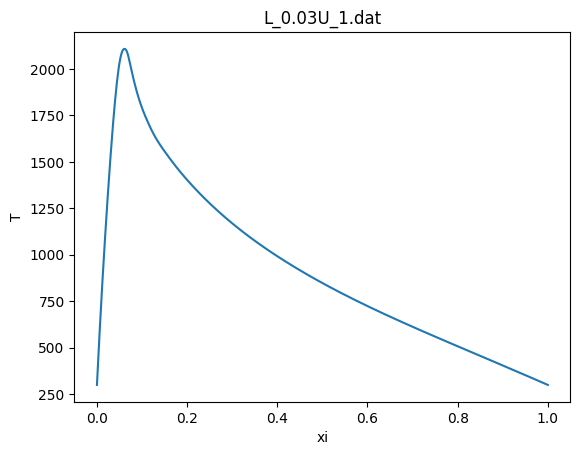

In [9]:
#DEBUGGING
import matplotlib.pyplot as plt

#Set data to plot
phi = 'T'
fileIndex = 0

#Grab data
phiBarFuncs = phiFuncs("/home/jaredwp91/Research/mnt/inferno/codes/flameJWP/run", phi)

#Print availlable files list
#filenames_with_index = []
print("Available Files:")
names = [key for key in phiBarFuncs.keys()]
for i in range(len(names)):
    print(i," ", names[i])

#Plot data
Xiplt = np.linspace(0,1,500)
plt.plot(Xiplt, phiBarFuncs[names[fileIndex]](Xiplt))
plt.title(names[fileIndex])
plt.xlabel('xi')
plt.ylabel(phi);
#get_data_files("/home/jaredwp91/Research/mnt/inferno/codes/flameJWP")